<div style="border:solid Chocolate 2px; padding: 40px">

<b> Привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хотел бы начать с просьбы представиться - к сожалению, ни в проекте, ни в Пачке не нашёл имени:)

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Добрый день. Меня зовут Дмитрий Козицкий. Буду далее указывать свои комментарии данным стилем.

# Проект Определение стоимости автомобилей

## Введение


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.


## Описание данных

#### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
#### Целевой признак
- Price — цена (евро)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

In [1]:
%pip install -q catboost==1.2.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q lightgbm==4.3.0

Note: you may need to restart the kernel to use updated packages.


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
from time import time

RANDOM_STATE = 42
TEST_SIZE = 0.25

matplotlib_axes_logger.setLevel('ERROR')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)
plt.rcParams["figure.figsize"] = (12,8)

sns.set()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Ты импортируешь библиотеки и модули, которые не используешь в проекте - так делать не стоит, так как ты забиваешь окружение лишними  инструментами.
    
В блоке импорта стоит оставить только то, что реально используется в проекте.
</div>

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Убрал неиспользуемые библиотеки

## Загрузка данных

In [5]:
df_cars = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
display(df_cars.head(5))
df_cars.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Данные загрузили.
    
При считывании данных из файла здорово перестраховывать себя от ошибок, связанных, например, с неверным указанием пути к файлу. А иногда бывает, что работаешь с файлом локально, выгружаешь его на сервер, ожидая, что он будет принимать данные, которые лежат на том же сервере, а код падает с ошибкой, потому что путь к файлу не поменялся с локального на серверный.
    
Для этого, например, можно использовать конструкцию `try-except`: сначала пробуешь локальный путь, при возникновении ошибки используется серверный путь (подробнее можешь почитать тут: https://pythonworld.ru/tipy-dannyx-v-python/isklyucheniya-v-python-konstrukciya-try-except-dlya-obrabotki-isklyuchenij.html).
    
Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')

Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных можно задать индекс-столбец - за это действие отвечает параметр `index_col`.

По загруженным данным можно сделать следующие выводы:
- размерность датасета 354369 х 16
- датасет содержит как числовые так и категориальные типы данных. Кроме полей которые содержат дату и имеют тип object (DateCrawled, DateCreated, LastSeen), все остальные типы соответствуют своим данным. Типы колонок DateCrawled, DateCreated, LastSeen надо перобразовать в соответствующие типы (date или timestamp)
- в некоторых колонках имеются пропуски

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Первичный осмотр есть.

## Предобработка данных

- Колонки DateCrawled, DateCreated, LastSeen приведены к типу datetime64
- Остальные колонки типа object приведены к типу string

In [6]:
df_cars_str_col_list = df_cars.select_dtypes(exclude=np.number).columns
df_cars[df_cars_str_col_list] = df_cars[df_cars_str_col_list].astype('string')

df_cars['DateCrawled'] = pd.to_datetime(df_cars['DateCrawled'])
df_cars['DateCreated'] = pd.to_datetime(df_cars['DateCreated'])
df_cars['LastSeen'] = pd.to_datetime(df_cars['LastSeen'])

df_cars.info()
df_cars.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,<NA>,1993,manual,0,golf,150000,0,petrol,volkswagen,<NA>,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,<NA>,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,<NA>,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Даты привели к нужному типу данных.

Колонка NumberOfPictures содержит значения все равные 0. В связи с этим она признана неинформативной и удалена из датасета

In [7]:
df_cars.describe()
df_cars = df_cars.drop(['NumberOfPictures'], axis = 1)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Верно, признак бесполезен для моделирования.

Для того, чтобы предварительно обнаружить дубликаты, надо определить набор аттрибутов на которых надо определять эти дубликаты. Во первых, надо из общего числа аттрибутов убрать целевой признак Price, потом убрать те входные признаки, которые не будут участвовать в работе модели.
На мой взгляд это такие служебные признаки как:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- LastSeen — дата последней активности пользователя

Обнаружено 34565 дубликатов для всех входных аттрибутов (исключая вышеперечисленные). Пока с ними ничего не буду делать, так как далее будет иметь место заполнение пропусков и я посмотрю на дубликаты после этой процедуры.

In [8]:
list_for_duplicates = ["Price", "DateCrawled", "DateCreated", "LastSeen"]
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')

Количество дубликатов: df_cars: 34565


Ананлиз данных (метод info()) показал, что пропуски имеют место только в категориальных колонках (кроме колонки Brand) и в связи с этим принято решение заполнить их в пайплайне SimpleImputer модой для соответствующего аттрибута. После этого еще раз провести проверку на дубликаты и уже после этого удалить имеющиеся дубликаты.

In [9]:
cat_col_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
def display_value_count(df, col_list):
    for c in col_list:
        print(f"------- {c} -------")
        display(df[c].value_counts(dropna = False))

display_value_count(df_cars, cat_col_list)

df_cars.info()

------- VehicleType -------


sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other          3288 
Name: VehicleType, dtype: Int64

------- Gearbox -------


manual    268251
auto      66285 
NaN       19833 
Name: Gearbox, dtype: Int64

------- Model -------


golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2               8    
rangerover            4    
serie_3               4    
range_rover_evoque    2    
serie_1               2    
Name: Model, Length: 251, dtype: Int64

------- FuelType -------


petrol      216352
gasoline    98720 
NaN         32895 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: Int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     247161
NaN    71154 
yes    36054 
Name: Repaired, dtype: Int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

Использую пайплайн для применения SimpleImputer на этапе предобработки данных. В пайплайне использую SimpleImputer  для замены NaN на моду для колонок из списка cat_col_list с категориальными признаками так как пропуски имеют место только для этих колонок.


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

В целом любая импутация пропусков сопряжена с риском внесения в модель ошибок, а удаление - с потерей обучающих примеров. При этом в случае удаления мы теряем часть бизнес-сценариев, так как ситуации, когда клиент не указывает какие-то параметры автомобиля - нередкость, и в идеале модель должна уметь обрабатывать и их.
        
При работе с категориальными признаками стоит использовать заглушки в виде новых значений категорий для заполнения пропусков: это позволит как сохранить наблюдения вместо их удаления, так и избавит нас от возможных ошибок при эмпирическом импутировании.

In [10]:
df_cars = df_cars.replace({pd.NA: np.nan})
df_cars_dtypes = df_cars.dtypes

X = df_cars.drop(['Price'], axis=1)
y = df_cars['Price']

simple_imp_pipeline = Pipeline(
    [
        (
            'simpleImputer_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('simple_imp_pipeline', simple_imp_pipeline, X.columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor)
    ]
)

df_cars_arr = pipe_final.fit_transform(X)
df_cars = pd.concat([pd.DataFrame(df_cars_arr, columns = X.columns),y], axis=1)
for col in df_cars.columns:
  df_cars[col] = df_cars[col].astype(df_cars_dtypes[col])
display_value_count(df_cars, cat_col_list)
df_cars.info()

------- VehicleType -------


sedan          128947
small          79831 
wagon          65166 
bus            28775 
convertible    20203 
coupe          16163 
suv            11996 
other          3288  
Name: VehicleType, dtype: int64

------- Gearbox -------


manual    288084
auto      66285 
Name: Gearbox, dtype: int64

------- Model -------


golf                  48937
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2               8    
rangerover            4    
serie_3               4    
serie_1               2    
range_rover_evoque    2    
Name: Model, Length: 250, dtype: int64

------- FuelType -------


petrol      249247
gasoline    98720 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     318315
yes    36054 
Name: Repaired, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   VehicleType        354369 non-null  object        
 2   RegistrationYear   354369 non-null  int64         
 3   Gearbox            354369 non-null  object        
 4   Power              354369 non-null  int64         
 5   Model              354369 non-null  object        
 6   Kilometer          354369 non-null  int64         
 7   RegistrationMonth  354369 non-null  int64         
 8   FuelType           354369 non-null  object        
 9   Brand              354369 non-null  string        
 10  Repaired           354369 non-null  object        
 11  DateCreated        354369 non-null  datetime64[ns]
 12  PostalCode         354369 non-null  int64         
 13  LastSeen           354369 non-null  datetime

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Пропуски обработаны.

После замены пропусков на моду еще раз проверил количество дубликатов и их число теперь увеличилось и равно 40351. Удаляю эти дубликаты. Если позже придется в рамках исправления возможных аномалий и выбросов заменять их на какие либо значения для определенных колонок - то процедуру проверки и удаления дубликатов на этом же множестве аттрибутов надо повторить.

In [11]:
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')
df_cars = df_cars.drop_duplicates(subset=df_cars.columns.difference(list_for_duplicates))
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')

Количество дубликатов: df_cars: 40351
Количество дубликатов: df_cars: 0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Удалены явные дубликаты.

In [12]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314018 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        314018 non-null  datetime64[ns]
 1   VehicleType        314018 non-null  object        
 2   RegistrationYear   314018 non-null  int64         
 3   Gearbox            314018 non-null  object        
 4   Power              314018 non-null  int64         
 5   Model              314018 non-null  object        
 6   Kilometer          314018 non-null  int64         
 7   RegistrationMonth  314018 non-null  int64         
 8   FuelType           314018 non-null  object        
 9   Brand              314018 non-null  string        
 10  Repaired           314018 non-null  object        
 11  DateCreated        314018 non-null  datetime64[ns]
 12  PostalCode         314018 non-null  int64         
 13  LastSeen           314018 non-null  datetime

## Исследовательский анализ данных

In [13]:
def plot_sub_plot_hist_boxplot(df, col_list, title):
    for col in col_list:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", ax = axes[0], title = 'Histogram')
        sns.boxplot(df[col], ax = axes[1]).set_title('Box plot')
        fig.suptitle(title, fontsize=20)
        plt.show()

def plot_pie_plot_for_columns(df, col_list, title):
    for col in col_list:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, col_list, title, normalizer = 1):
    for col in col_list:
        print(col)
        ax = df[col].value_counts().plot(kind='bar',  label='',  title=col);
        plt.title(f'{title} for {col}')
        if normalizer != 1:
          vals = ax.get_yticks()
          ax.set_yticklabels(['{:,.0%}'.format(x / normalizer) for x in vals])
        plt.show()

Для начала посмотрим на значения колонок с timestamps и RegistrationYear - как они сочетаются друг с другом

Из анализа графиков и вывода метода describe() для колонок *'DateCrawled', 'DateCreated', 'LastSeen'* видно, что данные по этим трем колонкам в основном сосредоточены в диапазоне 2016-01 - 2016-04. Выше правой границы значений нет, ниже левой границы есть небольшое количество выбросов до 2014-04

Проанализировав график и вывода метода decribe() атрибуту RegistrationYear - видно что его среднее и медиана находятся в районе 2003-2004 гг, но имеют место выбросы как в большую сторону вплоть до 9999, так и в меньшую сторону вплоть до 1000. Так как нет возможности выяснить как собирались эти данные и выяснить причину этих выбросов - то необходимо сначала избавиться от слишком явных выбросов - так как я не вижу тут больше других вариантов как и чем их можно было заменить. Так как max Значение аттрибута *DateCreated*  = 2016-04-07 то наибольшее валидное значение аттрибута RegistrationYear это 2016 г так как при создании анкеты нельзя указать автомобиль с годом регистрации в будущем (если это не ошибка ввода). Таким образом верхняя граница отсечки по аттрибуту RegistrationYear это 2016. Что касается нижней границы отсечки то возьмем ее условно равной 1950 годом - автомобили за более ранние даты от 1950 г до момента начала автомобильной эры (1900 г) представляют собой уже очень дорогие раритеты, ну а за период от 1000 до 1900 гг никаких автомобилей не было. В данном допущении я исхожу из того, что аттрибут RegistrationYear важен для работы модели, так как он на мой взгляд, является признаком, по которому можно охарактеризовать тот или иной автомобиль и мы не можем просто исключить его из входных признаков для модели.

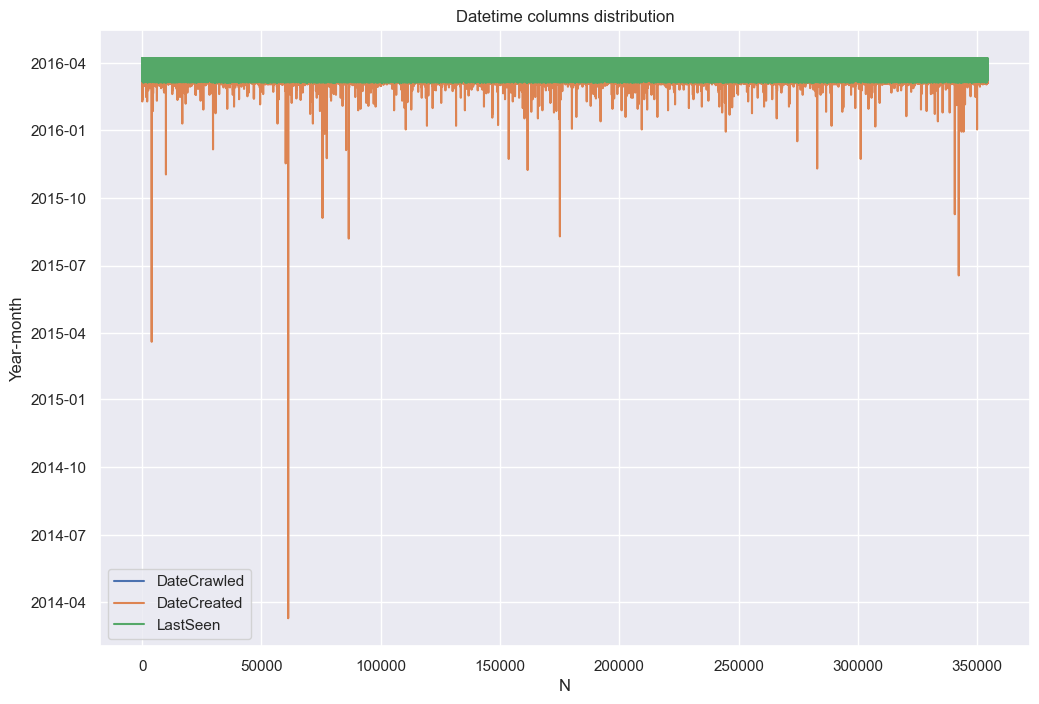

,DateCrawled,DateCreated,LastSeen
count,314018,314018,314018
unique,247447,109,160534
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 12:15:45
freq,7,12364,16
first,2016-03-05 14:06:24,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


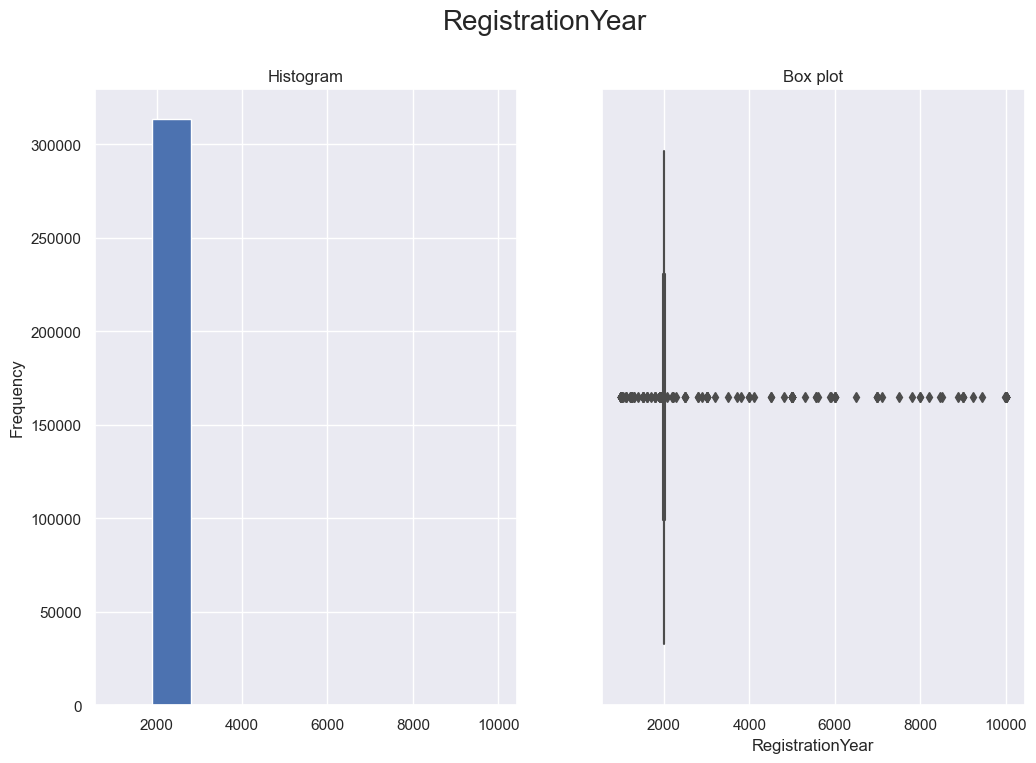

,RegistrationYear
count,314018.000000
mean,2004.183935
std,90.665822
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


In [14]:
ax = df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].plot.line()
ax.set_xlabel("N")
ax.set_ylabel("Year-month")
plt.title('Datetime columns distribution')
plt.show()
display(df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].describe())
plot_sub_plot_hist_boxplot(df_cars, ['RegistrationYear'],'RegistrationYear')
display(df_cars.loc[:,['RegistrationYear']].describe())

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

При работе с графиками важно соблюдать следующие правила:
1. Стоит подписать названия осей X и Y.
2. Также стоит дать название графику.
3. Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать - это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод `plt.show()`.
4. Графики нужно сделать больше - графики дефолтного размера не очень удобны для чтения. Удобнее будет настроить параметр `plt.rcParams["figure.figsize"] = (x,y)` сразу в ячейке импорта библиотек, и все графики проекта будут одного размера.
        
Несколько таких нехитрых приёмов очень повысят ценность твоей визуализации:)
        
Убедись, пожалуйста, что графики в твоём проекте соответствуют этим правилам.
</div>

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

В функции вывода графиков добавил тайтлы для subplots и подписи к осям - внизу общая ось для гистограммы слева и boxplot справа и там одна подпись к оси. Технические комментарии подавил. Графики сделал больше с использованием указанного тобой параметра - внутри функций установку этого параметра убрал.

После отсечки гистограмма RegistrationYear приобрела боллее читаемый вид, графики для аттрибутов 'DateCrawled', 'DateCreated', 'LastSeen' особо не изменились. Далее нужно провести проверку на соответствие даты из аттрибутов DateCreated и RegistrationYear, при этом DateCreated приведенный к году должен быть больше или равен RegistrationYear, другими словами нельзя при создании анкеты указать RegistrationYear в будущем.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  object        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  object        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  object        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  int64         
 8   FuelType           300569 non-null  object        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  object        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  int64         
 13  LastSeen           300569 non-null  datetime

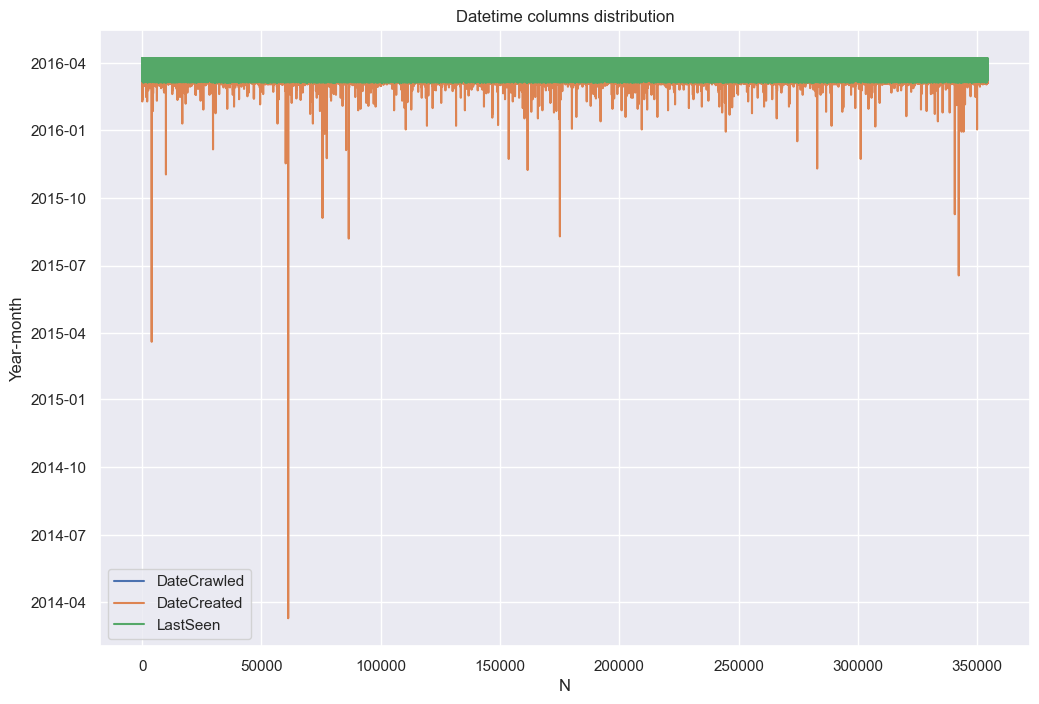

,DateCrawled,DateCreated,LastSeen
count,300569,300569,300569
unique,239378,108,154832
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-07 13:17:48
freq,7,11858,16
first,2016-03-05 14:06:24,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


In [15]:
df_cars_ryear_cut = df_cars[(df_cars['RegistrationYear'] <= 2016) & (df_cars['RegistrationYear'] >= 1950)]
df_cars_ryear_cut.info()
ax = df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].plot.line()
ax.set_xlabel("N")
ax.set_ylabel("Year-month")
plt.title('Datetime columns distribution')
plt.show()
display(df_cars_ryear_cut.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']].describe())

Тут я вижу, что записей для которых не выполняется указанное выше условие в датафрейме нет - то есть даты  DateCreated и RegistrationYear согласованы

In [16]:
df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['DateCreated'].dt.strftime('%Y')
df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['CreatedYear'].astype('int64')
print(df_cars_ryear_cut['Brand'].count())
df_cars_ryear_cut_new = df_cars_ryear_cut[df_cars_ryear_cut['CreatedYear'] >= df_cars_ryear_cut['RegistrationYear']]
print(df_cars_ryear_cut_new['Brand'].count())

300569
300569


/var/folders/f_/cl238sk96cjc68_lpl98ybgw0000gn/T/ipykernel_2158/132408727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['DateCreated'].dt.strftime('%Y')
/var/folders/f_/cl238sk96cjc68_lpl98ybgw0000gn/T/ipykernel_2158/132408727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cars_ryear_cut['CreatedYear'] = df_cars_ryear_cut['CreatedYear'].astype('int64')


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> По году регистрации фильтрация корректна.

In [17]:
df_cars_ryear_cut = df_cars_ryear_cut.drop(['CreatedYear'], axis=1)
df_cars_ryear_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  object        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  object        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  object        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  int64         
 8   FuelType           300569 non-null  object        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  object        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  int64         
 13  LastSeen           300569 non-null  datetime

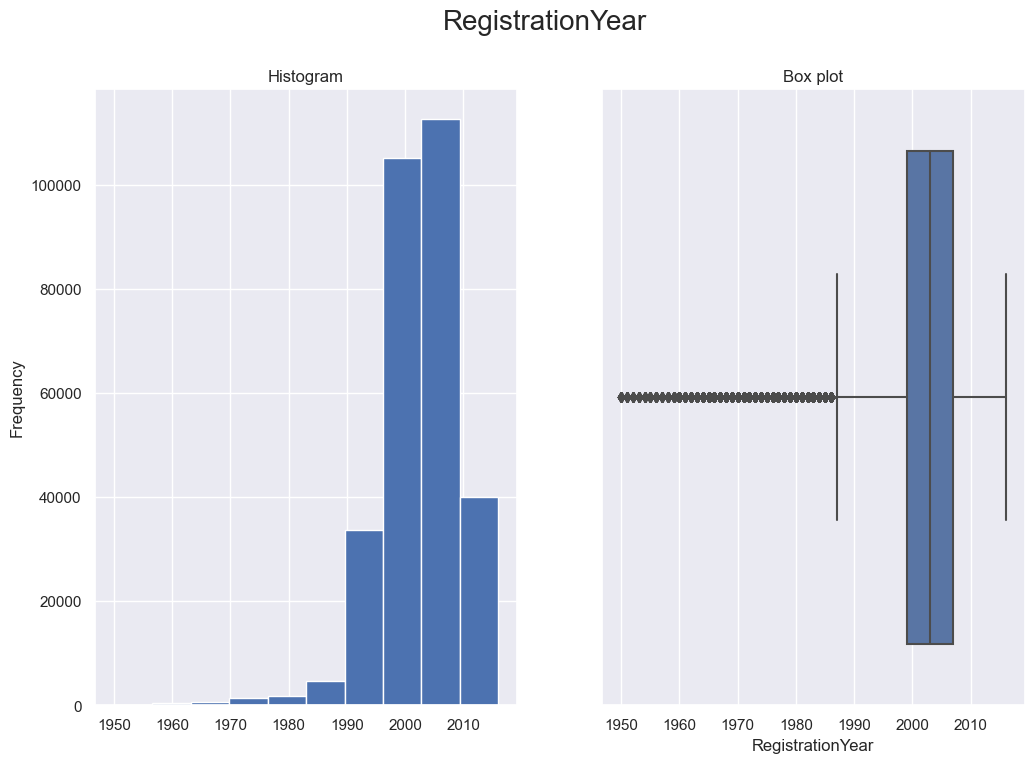

,RegistrationYear
count,300569.000000
mean,2002.446872
std,6.938305
min,1950.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


In [18]:
plot_sub_plot_hist_boxplot(df_cars_ryear_cut, ['RegistrationYear'],'RegistrationYear')
display(df_cars_ryear_cut.loc[:,['RegistrationYear']].describe())

Поменял тип для аттрибутов с object на string. PostalCode и RegistrationMonth также сделал категориальными переменными

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> А нужны ли нам в принципе два эти признака для моделирования? Можем проверить, например, с помощью корреляции с целевым признаком.
    
Если признаки удалятся, не забудь проверить наличие новых дубликатов.

In [19]:
int_to_string_col_list = ['RegistrationMonth', 'PostalCode', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
#df_cars.info()
df_cars_ryear_cut[int_to_string_col_list] = df_cars_ryear_cut[int_to_string_col_list].astype('string')
df_cars_ryear_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300569 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        300569 non-null  datetime64[ns]
 1   VehicleType        300569 non-null  string        
 2   RegistrationYear   300569 non-null  int64         
 3   Gearbox            300569 non-null  string        
 4   Power              300569 non-null  int64         
 5   Model              300569 non-null  string        
 6   Kilometer          300569 non-null  int64         
 7   RegistrationMonth  300569 non-null  string        
 8   FuelType           300569 non-null  string        
 9   Brand              300569 non-null  string        
 10  Repaired           300569 non-null  string        
 11  DateCreated        300569 non-null  datetime64[ns]
 12  PostalCode         300569 non-null  string        
 13  LastSeen           300569 non-null  datetime

Далее я вывожу статситику по категориальным признакам - 'VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'PostalCode' - такие методы как describe, value_counts и bar plot (в bar plot не включил PostalCode так как там очень большое количество уникальных значений и график неинформативен и очень долго строится). Статистика по RegistrationMonth показывает что этот аттрибут принимает значения от 0 до 12 включительно то есть 13 различных значений - а месяцев в году 12. При этом частота повторения каждого месяца примерно одинакова и в связи с этим непонятно как быть с лишним месяцем - то ли брать за начальное значение 0 и тогда лишним будет месяц 12, то ли отсчет вести от месяца 1 и тогда лишним будет месяц 0 и также непонятно что делать с этим лишним месяцем - заменять его на моду множества - так частота примерно одинакова. Отбросить данные с "лишним" месяцем тоже нельзя - так как непонятно какой месяц считать лишним. Поскольку у меня нет информации с чем связана подобная ошибка ввода и как ее надо исправлять - я предлагаю оставить эту ситуаци как есть и ничего с ней не делать. В связи с чем в предсказании модели по аттрибуту Month будет заложена некая погрешность - можно в будущем попробовать удалить этот аттрибут и посмореть как это оразится на метрике.

,VehicleType,Gearbox,Model,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
count,300569,300569,300569,300569,300569,300569,300569,300569
unique,8,2,250,13,7,40,2,8138
top,sedan,manual,golf,0,petrol,volkswagen,no,65428
freq,101576,243941,40556,30802,210411,64402,268218,480


sedan          101576
small          70014 
wagon          57070 
bus            25762 
convertible    17991 
coupe          14470 
suv            10587 
other          3099  
Name: VehicleType, dtype: Int64

manual    243941
auto      56628 
Name: Gearbox, dtype: Int64

golf                  40556
other                 21964
3er                   16823
polo                  11001
corsa                 10354
                      ...  
kalina                5    
serie_3               4    
rangerover            3    
serie_1               2    
range_rover_evoque    1    
Name: Model, Length: 250, dtype: Int64

0     30802
3     29291
6     26857
4     25157
5     24899
7     23398
10    22027
11    20445
12    20356
9     20297
1     19745
8     19248
2     18047
Name: RegistrationMonth, dtype: Int64

petrol      210411
gasoline    84641 
lpg         4538  
cng         488   
hybrid      216   
other       187   
electric    88    
Name: FuelType, dtype: Int64

volkswagen        64402
opel              33382
bmw               31350
mercedes_benz     27546
audi              25180
ford              21365
renault           15024
peugeot           9285 
fiat              8138 
seat              5733 
mazda             4831 
skoda             4674 
smart             4553 
citroen           4439 
nissan            4227 
toyota            4072 
hyundai           3071 
sonstige_autos    2938 
volvo             2788 
mini              2729 
mitsubishi        2625 
honda             2442 
kia               2093 
suzuki            2017 
alfa_romeo        2007 
chevrolet         1532 
chrysler          1278 
dacia             769  
daihatsu          691  
porsche           687  
subaru            686  
jeep              597  
trabant           532  
land_rover        489  
saab              465  
daewoo            457  
jaguar            448  
rover             414  
lancia            413  
lada              200  
Name: Brand, dtype: Int64

no     268218
yes    32351 
Name: Repaired, dtype: Int64

65428    480
66333    267
78224    263
32257    261
52525    252
        ... 
82067    1  
86502    1  
29487    1  
37635    1  
21131    1  
Name: PostalCode, Length: 8138, dtype: Int64

VehicleType


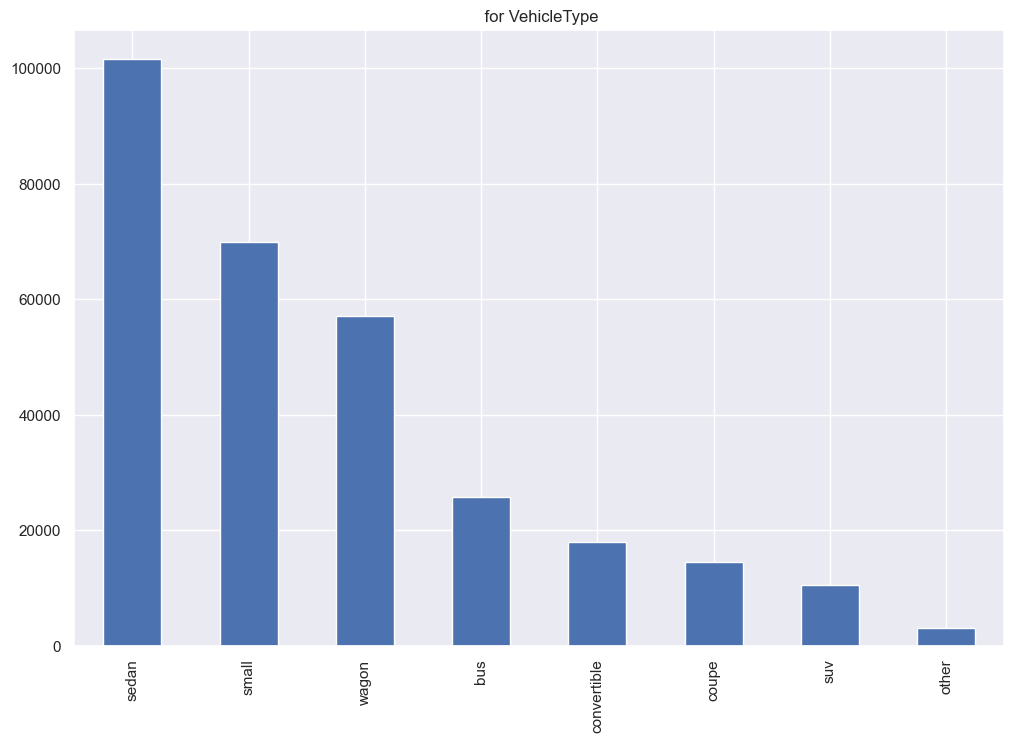

Gearbox


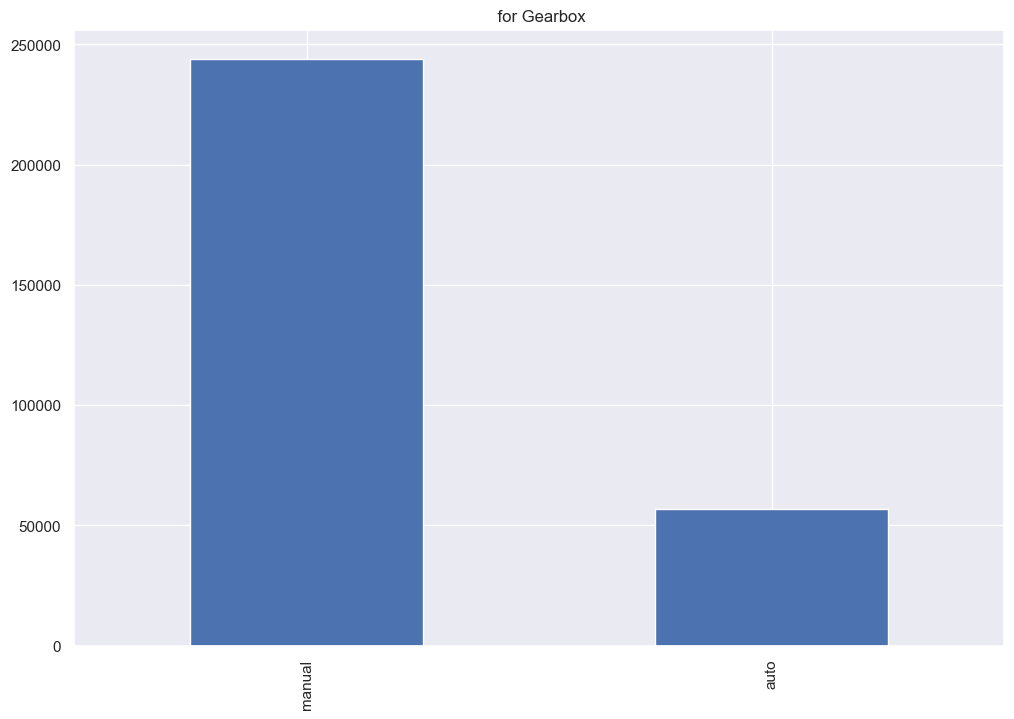

Model


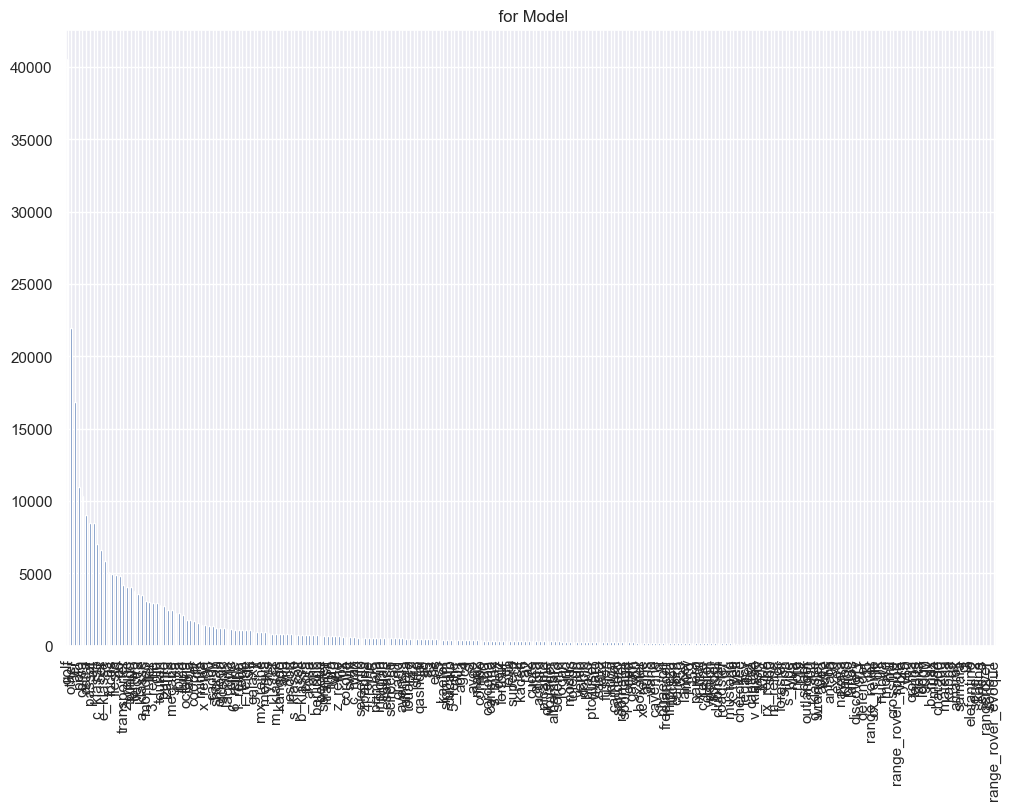

RegistrationMonth


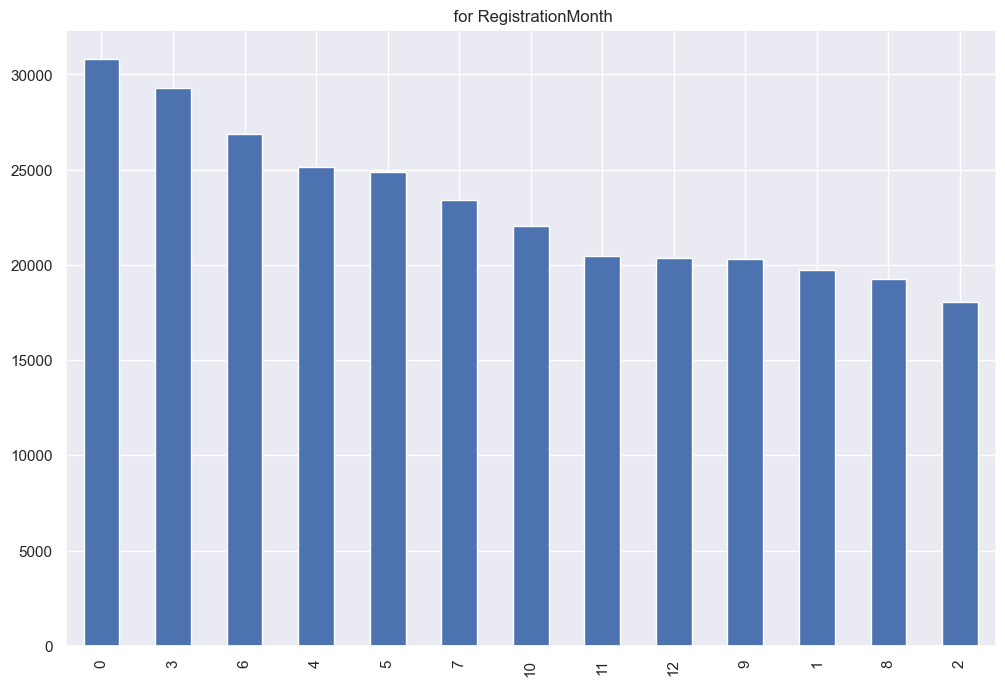

FuelType


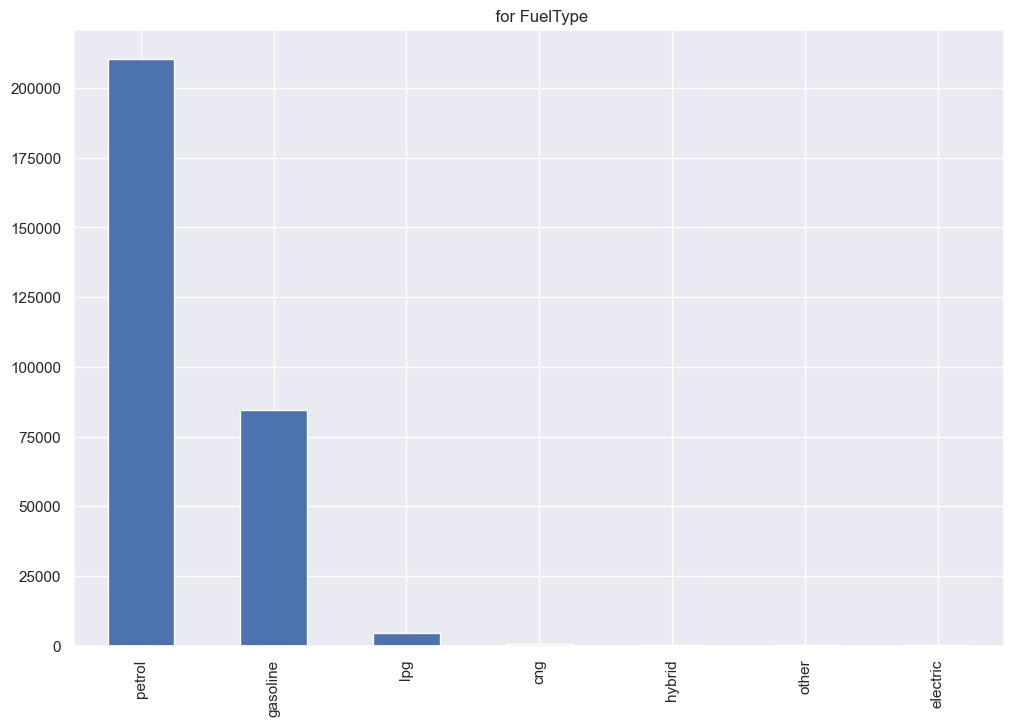

Brand


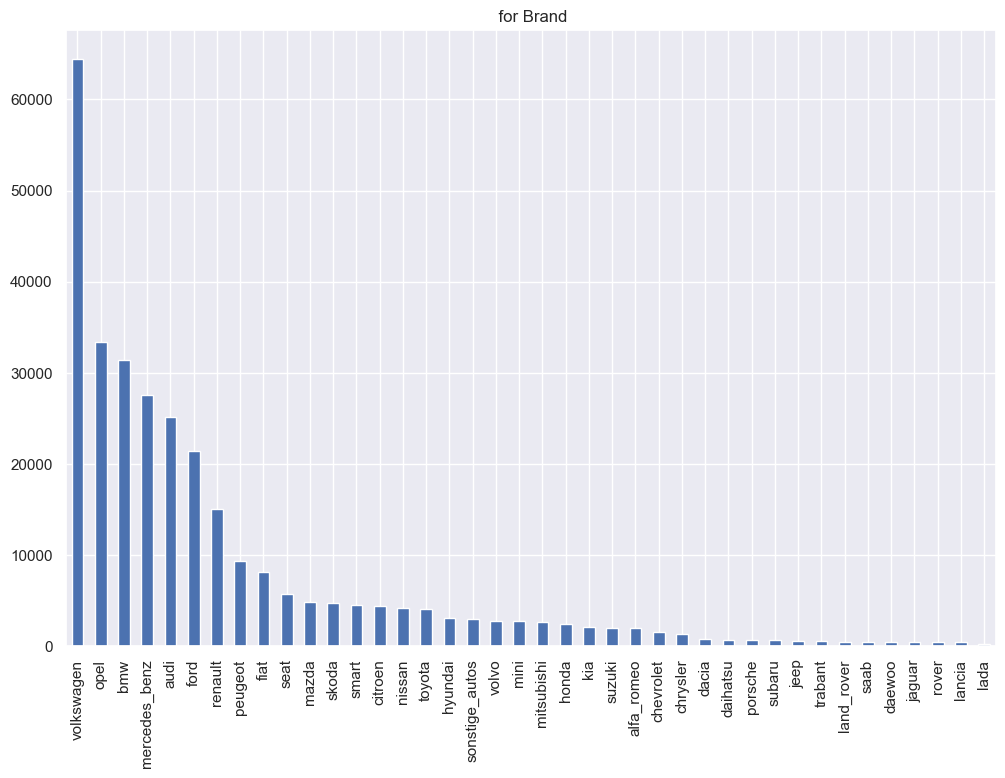

Repaired


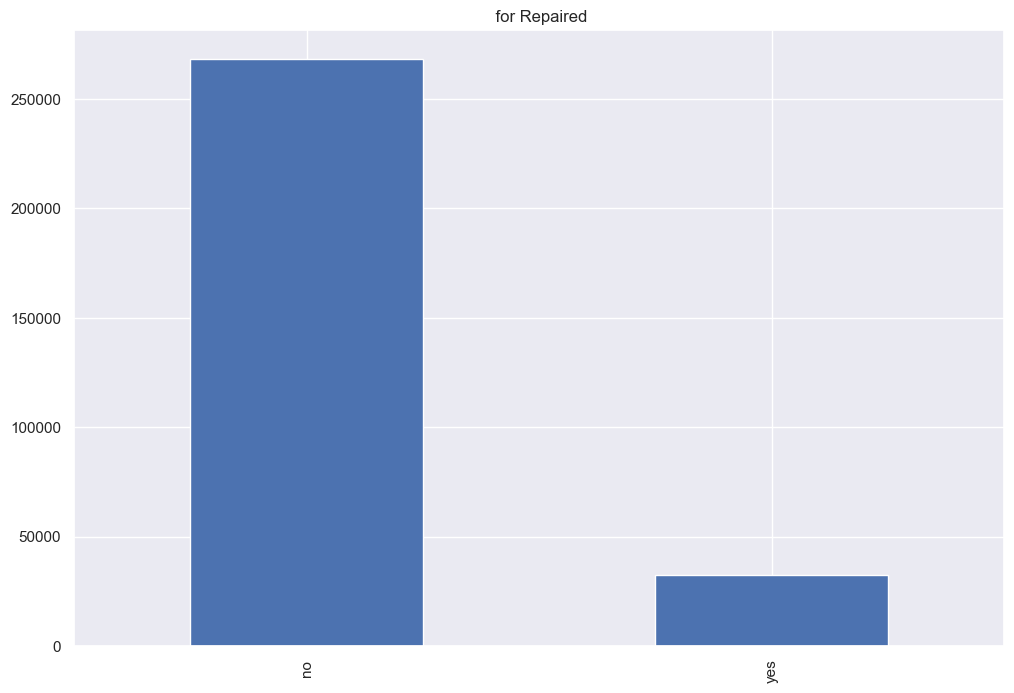

In [20]:
cat_list = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'PostalCode']
display(df_cars_ryear_cut.loc[:,cat_list].describe())
for c in cat_list:
    display(df_cars_ryear_cut[c].value_counts())

plot_bar_plot_for_columns(df_cars_ryear_cut, ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'], "")

Анализ гистограмм числовых аттрибутов 'Power', 'Kilometer' показал, что:
- аттрибут Power варьируется в диапазоне от 0 до 20000 л.c. Величина 0 это очевидно ошибочное значение (и ряд значений от 0 до некоего минимального 50 л.c. также ошибочны), но и  значения свыше 1000 л.c. также являются ошибочными - 1000 л.c. это мощность гоночного болида. Поэтому я предлагаю сделать отсечку по этому аттрибуту по диапазону 50; 1000 так как я не знаю как вводились эти данные и с чем может связана такая ошибка
- аттрибут Kilometer принимает min и max значения равными 5000 и 150000 что кажется мне вполне валидными значениями для пробега

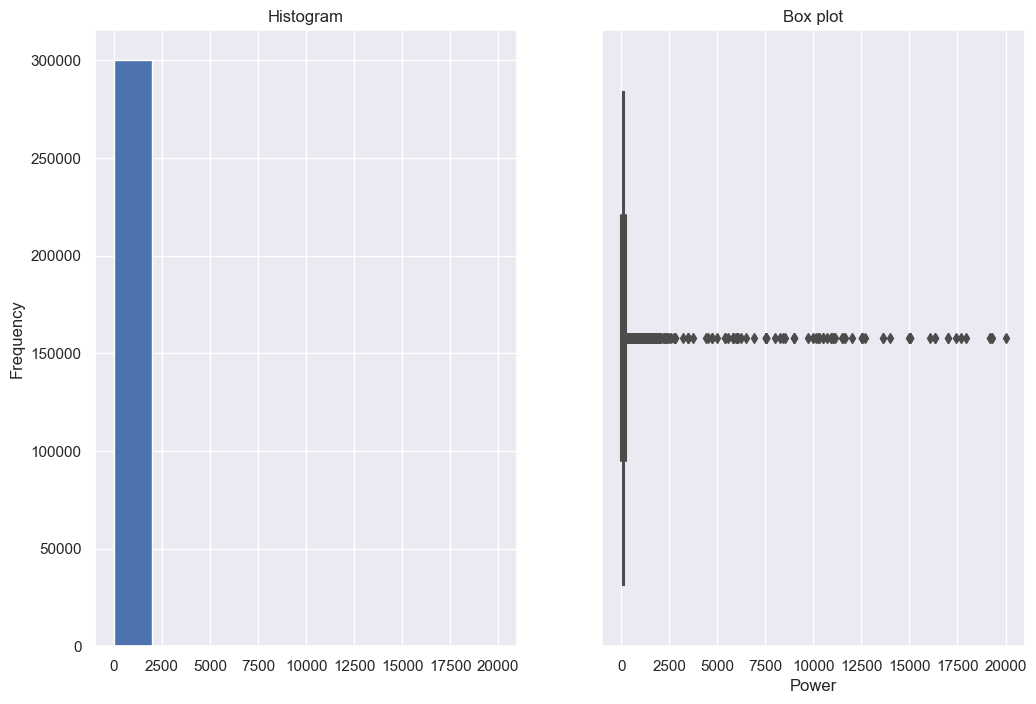

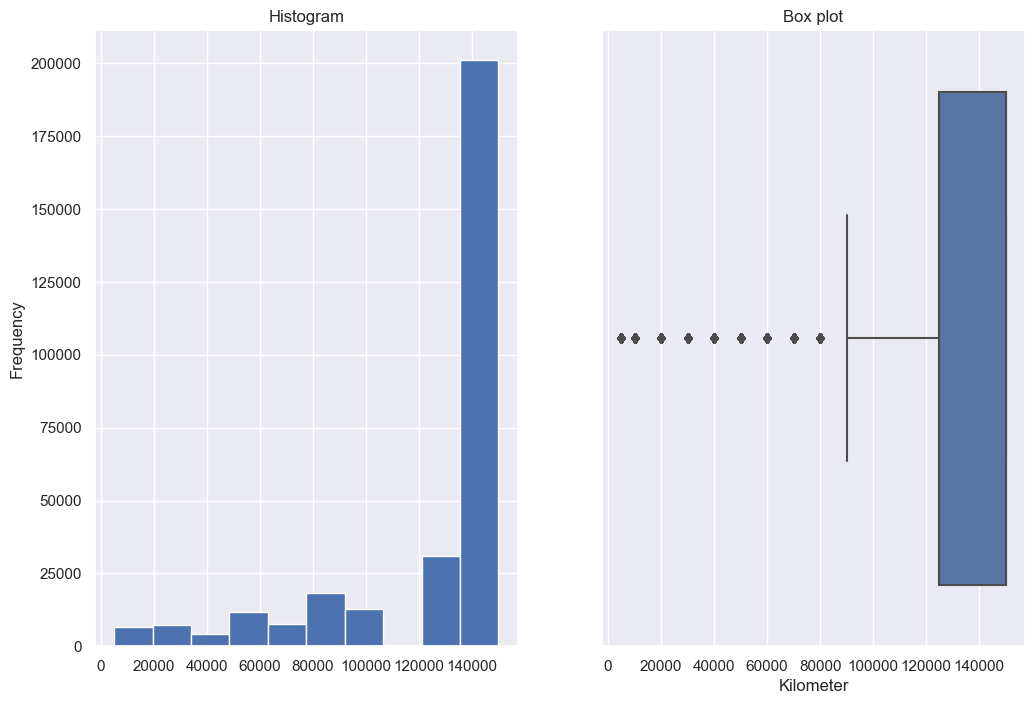

,Power,Kilometer
count,300569.000000,300569.000000
mean,110.789389,127999.311306
std,196.500722,38039.817259
min,0.000000,5000.000000
25%,69.000000,125000.000000
50%,105.000000,150000.000000
75%,143.000000,150000.000000
max,20000.000000,150000.000000


In [21]:
num_list = ['Power', 'Kilometer']
plot_sub_plot_hist_boxplot(df_cars_ryear_cut, num_list, '')
display(df_cars_ryear_cut.loc[:,num_list].describe())

Графики для Power после обрезки

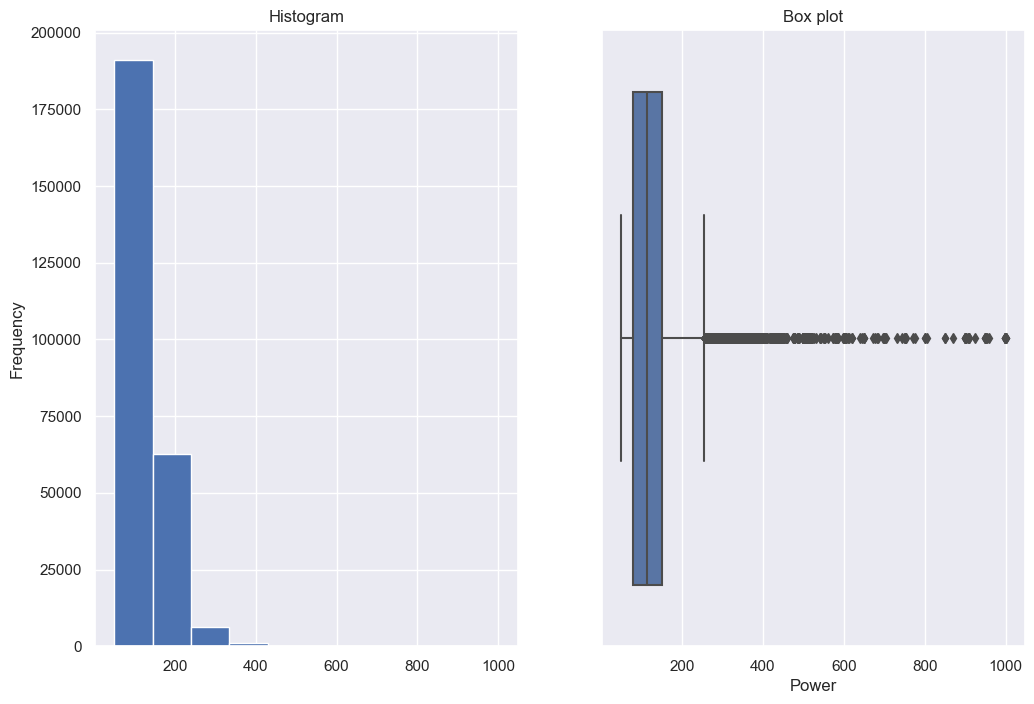

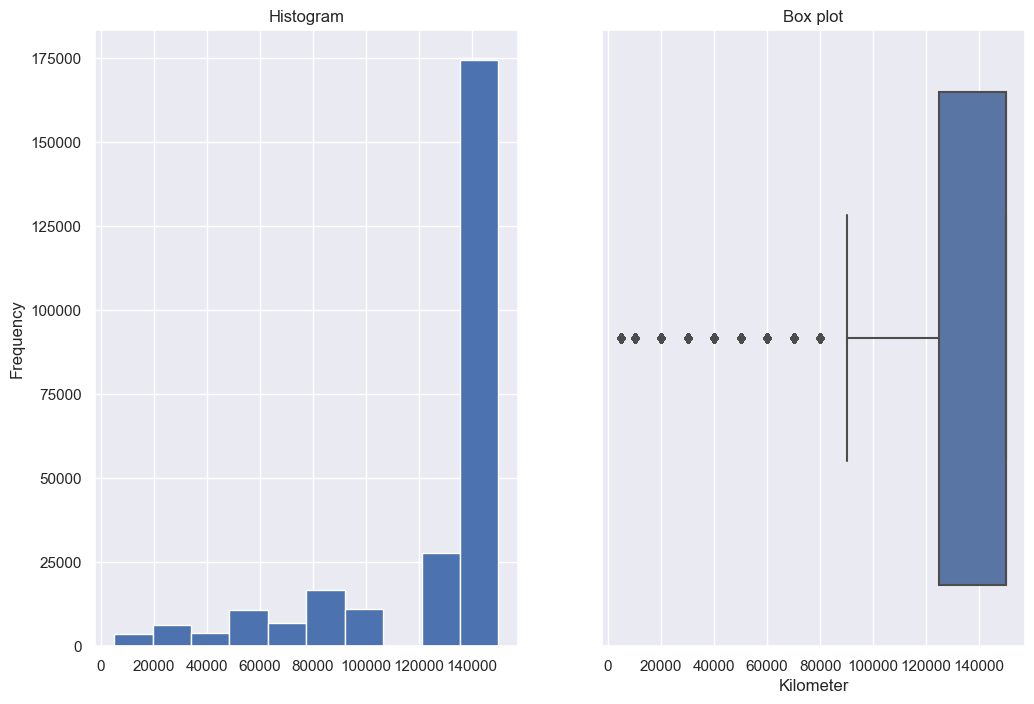

,Power,Kilometer
count,261506.000000,261506.000000
mean,122.205697,128534.966693
std,54.453401,36721.431135
min,50.000000,5000.000000
25%,80.000000,125000.000000
50%,114.000000,150000.000000
75%,150.000000,150000.000000
max,1000.000000,150000.000000


In [22]:
df_cars_ryear_cut_power = df_cars_ryear_cut[(df_cars_ryear_cut['Power'] <= 1000) & (df_cars_ryear_cut['Power'] >= 50)]
plot_sub_plot_hist_boxplot(df_cars_ryear_cut_power, num_list, '')
display(df_cars_ryear_cut_power.loc[:,num_list].describe())

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> По мощности фильтрация также в порядке.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> На предмет аномалий нужно проверить также целевой признак `Price`.

Scatter pair plot для числовых аттрибутов 'RegistrationYear', 'Kilometer', 'Power' не показал каких либо аномалий и выраженной линейной зависимости

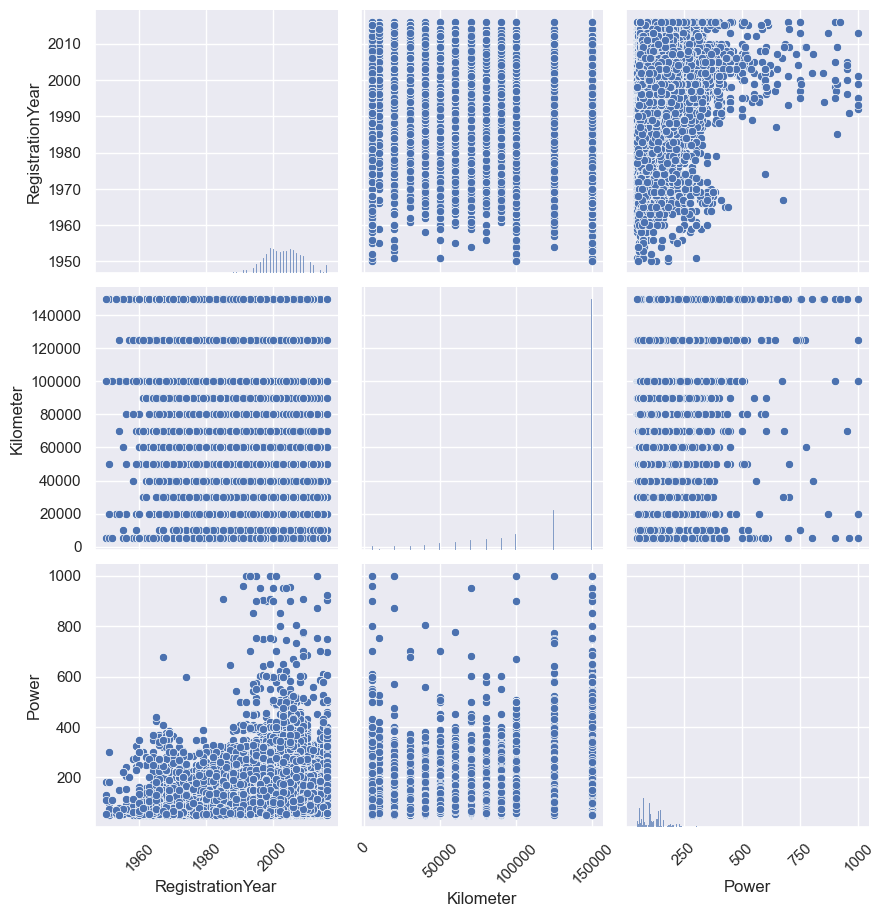

In [23]:
scatter_col_list = ['RegistrationYear', 'Kilometer', 'Power']
g = sns.pairplot(data = df_cars_ryear_cut_power, vars = scatter_col_list, height=3)
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=45)

Убираю из датафрейма df_cars_ryear_cut_power колонки 'DateCrawled', 'DateCreated', 'LastSeen' которые не нужны для моделирования так как представляют собой справочную информацию

In [24]:
df_cars_ryear_cut_power = df_cars_ryear_cut_power.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
df_cars_ryear_cut_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261506 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        261506 non-null  string
 1   RegistrationYear   261506 non-null  int64 
 2   Gearbox            261506 non-null  string
 3   Power              261506 non-null  int64 
 4   Model              261506 non-null  string
 5   Kilometer          261506 non-null  int64 
 6   RegistrationMonth  261506 non-null  string
 7   FuelType           261506 non-null  string
 8   Brand              261506 non-null  string
 9   Repaired           261506 non-null  string
 10  PostalCode         261506 non-null  string
 11  Price              261506 non-null  int64 
dtypes: int64(4), string(8)
memory usage: 25.9 MB


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Даты удалены, порядок.

Фик матрица была построена по всем аттрибутам датафрейма df_cars_ryear_cut_power с учетом целевого аттрибута Price. Из анализа этой матрицы я вижу:
- корреляция между аттрибутами Model и Brand = 1. Это объяснимо так как Модель в данном случае является Брендом и наоборот - между ними взаимно однозначное соответствие (возможно отношение один ко многим для связи Brand -> Model)
- корреляция между Model и VehicleType довольно высока = 0.91
- корреляция между Brand и VehicleType ниже и = 0.62

В случае линейной модели предполагалось убрать из входных аттрибутов Model так как он имеет высокую корреляцию с двумя другими аттрибутами Brand и VehicleType - но для буст-моделей это несущественно. Также я не вижу высокой кореляции всех входных признаков с целевым - самое высокое значение для корреляции Price - RegistrationYear = 0.67 что меньше условного порога 0.8. 
Далее можно попробовать оценить кандидатов на исключение из входных признаков на основе оценки их дисперсии и отбросить признаки с низкой дисперсией - но я таких признаков в данном датафрейме не вижу.  Поэтому я предлагаю в качестве начальной итерации использовать полный набор признаков (после удаления колонок типа datetime), далее посмотреть метрики для трех моделей (CatBoost, LGBM, DesicionTreeRegressor) и если я не получу метрику RMSE в нужном диапазоне хотя бы на одной из моделей, то далее используя подход feature_importance начинать убирать признаки начиная с наименее важного. Единственный признак, который я хочу дропнуть на данном этапе - это PostalCode так как это категориальный признак и у него очень большое количество категорий (>8000) - причем на этот факт были ворнинги и на уровне построения фик-матрицы, а на этапе построения модели DesicionTreeRegressor она просто вылетела по факту нехватки памяти (при этом бустовые модели отработали с этим признаком нормально). Поэтому я предлагаю на этом этапе дропнуть признак PostalCode для того, чтобы для всех трех моделей были равные входные датасеты. Далее если не выполнится условие соответствия метрики хотя бы для одной модели - то буду думать что делать с этим дальше.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Этот шаг может быть полезен для линейных моделей, однако мультиколлинеарность не представляет проблемы для древесных и бустинговых моделей - можно рассмотреть вариант создания двух датасетов с и без этого признака в зависимости от модели.

In [25]:
#phik_overview = phik_matrix(df_cars_ryear_cut_power[df_cars_ryear_cut_power.columns.difference(['Price'])], interval_cols=['Power'])
phik_overview = phik_matrix(df_cars_ryear_cut_power, interval_cols=['Power', 'Price'])

/Users/Theo/miniconda3/envs/yap/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable PostalCode is large: 8118. Are you sure this is not an interval variable? Analysis for pairs of variables including PostalCode can be slow.
  warnings.warn(
/Users/Theo/miniconda3/envs/yap/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2021382. Are interval variables set correctly?
  warnings.warn(


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
    
`Kilometer` и `RegistrationYear` - дискретные признаки, их не нужно передавать в `interval_cols`.

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Для фик матрицы убрал Kilometer и RegistrationYear из интервальных колонок и добавил датасет целевой признак Price как интервальный

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Price
VehicleType,1.000000,0.336116,0.277047,0.288583,0.907068,0.194521,0.088972,0.318182,0.623438,0.061777,0.231729,0.253887
RegistrationYear,0.336116,1.000000,0.133513,0.174997,0.657169,0.637433,0.209778,0.359222,0.349626,0.161577,0.572042,0.671622
Gearbox,0.277047,0.133513,1.000000,0.540583,0.610460,0.030767,0.053426,0.142018,0.498033,0.030874,0.179673,0.325460
Power,0.288583,0.174997,0.540583,1.000000,0.640127,0.080567,0.032772,0.147257,0.492810,0.048593,0.185060,0.407128
Model,0.907068,0.657169,0.610460,0.640127,1.000000,0.432833,0.161234,0.520260,0.997582,0.123823,0.773260,0.566631
Kilometer,0.194521,0.637433,0.030767,0.080567,0.432833,1.000000,0.112112,0.157206,0.263191,0.098288,0.234872,0.329740
RegistrationMonth,0.088972,0.209778,0.053426,0.032772,0.161234,0.112112,1.000000,0.085399,0.084210,0.066257,0.222069,0.138835
FuelType,0.318182,0.359222,0.142018,0.147257,0.520260,0.157206,0.085399,1.000000,0.278465,0.034273,0.180510,0.254550
Brand,0.623438,0.349626,0.498033,0.492810,0.997582,0.263191,0.084210,0.278465,1.000000,0.083186,0.528516,0.352707
Repaired,0.061777,0.161577,0.030874,0.048593,0.123823,0.098288,0.066257,0.034273,0.083186,1.000000,0.115973,0.306736


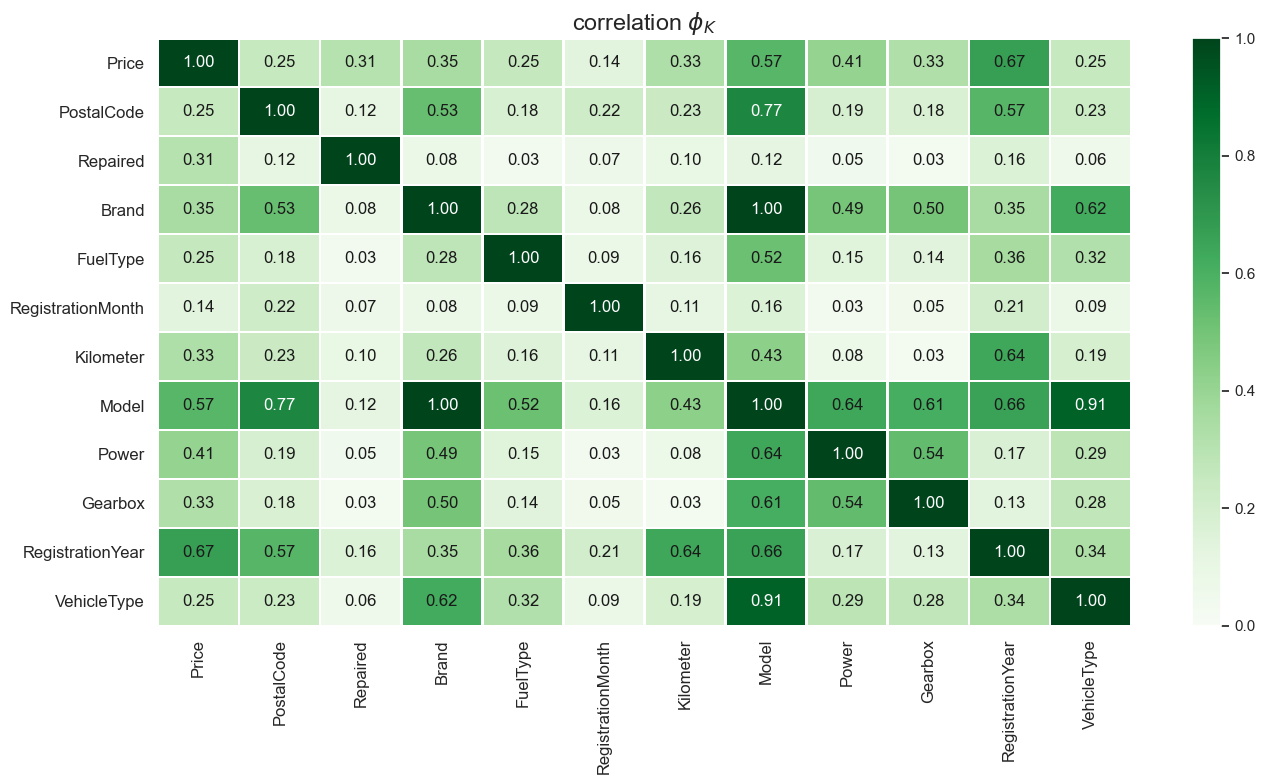

In [26]:
display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Есть анализ корреляции - молодец, что используешь `phik` для анализа и нелинейных зависимостей, а также настраиваешь `interval_cols` для корректной оценки корреляции для переменных разного типа.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
    
А почему в исследовании нет `Price`?

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Добавил признак Price в рассчет фик матрицы

In [27]:
df_cars_ryear_cut_power = df_cars_ryear_cut_power.drop(['PostalCode'], axis=1)
df_cars_ryear_cut_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261506 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        261506 non-null  string
 1   RegistrationYear   261506 non-null  int64 
 2   Gearbox            261506 non-null  string
 3   Power              261506 non-null  int64 
 4   Model              261506 non-null  string
 5   Kilometer          261506 non-null  int64 
 6   RegistrationMonth  261506 non-null  string
 7   FuelType           261506 non-null  string
 8   Brand              261506 non-null  string
 9   Repaired           261506 non-null  string
 10  Price              261506 non-null  int64 
dtypes: int64(4), string(7)
memory usage: 23.9 MB


Фик матрица после удаления аттрибута PostalCode

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,Price
VehicleType,1.000000,0.336116,0.277047,0.288583,0.907068,0.194521,0.088972,0.318182,0.623438,0.061777,0.253887
RegistrationYear,0.336116,1.000000,0.133513,0.174997,0.657169,0.637433,0.209778,0.359222,0.349626,0.161577,0.671622
Gearbox,0.277047,0.133513,1.000000,0.540583,0.610460,0.030767,0.053426,0.142018,0.498033,0.030874,0.325460
Power,0.288583,0.174997,0.540583,1.000000,0.640127,0.080567,0.032772,0.147257,0.492810,0.048593,0.407128
Model,0.907068,0.657169,0.610460,0.640127,1.000000,0.432833,0.161234,0.520260,0.997582,0.123823,0.566631
Kilometer,0.194521,0.637433,0.030767,0.080567,0.432833,1.000000,0.112112,0.157206,0.263191,0.098288,0.329740
RegistrationMonth,0.088972,0.209778,0.053426,0.032772,0.161234,0.112112,1.000000,0.085399,0.084210,0.066257,0.138835
FuelType,0.318182,0.359222,0.142018,0.147257,0.520260,0.157206,0.085399,1.000000,0.278465,0.034273,0.254550
Brand,0.623438,0.349626,0.498033,0.492810,0.997582,0.263191,0.084210,0.278465,1.000000,0.083186,0.352707
Repaired,0.061777,0.161577,0.030874,0.048593,0.123823,0.098288,0.066257,0.034273,0.083186,1.000000,0.306736


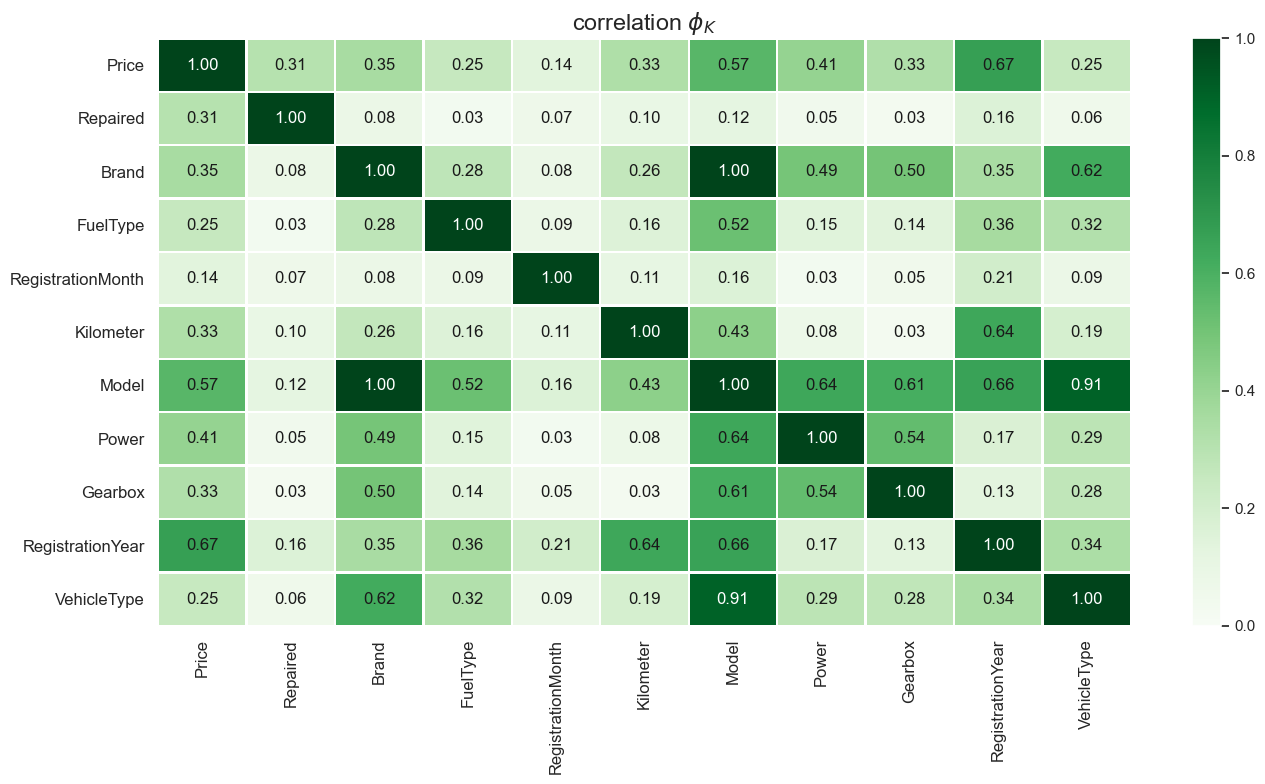

In [28]:
#phik_overview = phik_matrix(df_cars_ryear_cut_power[df_cars_ryear_cut_power.columns.difference(['Price'])], interval_cols=scatter_col_list)
phik_overview = phik_matrix(df_cars_ryear_cut_power, interval_cols=['Power', 'Price'])
display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

## Подготовка данных и обучение моделей

Преобразуем тип колонок RegistrationYear и Kilometer в string так как это категориальные признаки

In [49]:
model_map = {}
df_cars_ryear_cut_power[['RegistrationYear', 'Kilometer']] = df_cars_ryear_cut_power[['RegistrationYear', 'Kilometer']].astype('string')
df_cars_ryear_cut_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261506 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        261506 non-null  string
 1   RegistrationYear   261506 non-null  string
 2   Gearbox            261506 non-null  string
 3   Power              261506 non-null  int64 
 4   Model              261506 non-null  string
 5   Kilometer          261506 non-null  string
 6   RegistrationMonth  261506 non-null  string
 7   FuelType           261506 non-null  string
 8   Brand              261506 non-null  string
 9   Repaired           261506 non-null  string
 10  Price              261506 non-null  int64 
dtypes: int64(2), string(9)
memory usage: 23.9 MB


Выделяем датафреймы для входных и целевого признака, производим разбиение на тренировочную, валидационную и тестовую выборку

In [50]:
X = df_cars_ryear_cut_power.drop(['Price'], axis=1)
y = df_cars_ryear_cut_power['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Сплитование выполнено.

Применяем модель CatBoostRegressor с параметрами iterations=10,learning_rate=1,depth=2 

In [57]:
cat_columns = ['RegistrationMonth', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'Repaired', 'RegistrationYear', 'Kilometer']
catboostModel = CatBoostRegressor(iterations=10,learning_rate=1,depth=2, random_seed=RANDOM_STATE)

start = time()
catboostModel.fit(X_train, y_train, cat_features=cat_columns, eval_set = (X_valid, y_valid));
preds_cbm = catboostModel.predict(X_valid)
end = time()
model_time = (end-start)
rmse_cb = sqrt(mean_squared_error(y_valid, preds_cbm))

model_map['CatBoostRegressor'] = (rmse_cb, model_time)

print(model_map)


0:	learn: 3201.3486682	test: 3177.8356276	best: 3177.8356276 (0)	total: 32.6ms	remaining: 294ms
1:	learn: 3000.9832952	test: 2978.1597967	best: 2978.1597967 (1)	total: 53.7ms	remaining: 215ms
2:	learn: 2897.7499066	test: 2881.8920756	best: 2881.8920756 (2)	total: 81.5ms	remaining: 190ms
3:	learn: 2778.8994807	test: 2761.1348906	best: 2761.1348906 (3)	total: 101ms	remaining: 152ms
4:	learn: 2704.0362085	test: 2691.8708627	best: 2691.8708627 (4)	total: 117ms	remaining: 117ms
5:	learn: 2583.7793923	test: 2584.7042764	best: 2584.7042764 (5)	total: 138ms	remaining: 92ms
6:	learn: 2501.5808790	test: 2515.8647826	best: 2515.8647826 (6)	total: 154ms	remaining: 66.1ms
7:	learn: 2431.9632398	test: 2420.7289636	best: 2420.7289636 (7)	total: 171ms	remaining: 42.7ms
8:	learn: 2376.0260817	test: 2375.0798666	best: 2375.0798666 (8)	total: 187ms	remaining: 20.8ms
9:	learn: 2342.7591070	test: 2334.9958562	best: 2334.9958562 (9)	total: 203ms	remaining: 0us

bestTest = 2334.995856
bestIteration = 9

{'Ca

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

При использовании моделей (кроме линейной регрессии) важно настроить параметр `random_state`, чтобы результаты работы над проектом были воспроизводимы при его перезапуске.

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Добавил параметр random_seed=RANDOM_STATE в вызов конструктора модели CatBoostRegressor

Готовим данные для LGBMRegressor (с заменой типа string на category) и строим модель LGBMRegressor

In [58]:
X_lgbm_train = X_train.copy()
X_lgbm_valid = X_valid.copy()

def LGBMdfCreator(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'string':
            df[c] = df[c].astype('category')

LGBMdfCreator(X_lgbm_train)
LGBMdfCreator(X_lgbm_valid)

gbm2 = LGBMRegressor(objective='rmse', random_state=RANDOM_STATE, early_stopping_rounds = 5, n_estimators=10000)
start = time()
gbm2.fit(X_lgbm_train,  y_train, eval_set=[(X_lgbm_valid, y_valid)], eval_metric='rmse')
preds_gbm2 = gbm2.predict(X_lgbm_valid)
end = time()
model_time = (end-start)
rmse_gbm2 = sqrt(mean_squared_error(y_valid, preds_gbm2))

model_map['LGBMRegressor'] = (rmse_gbm2, model_time)

print(model_map)

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 147096, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score 4782.448823
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[323]	valid_0's rmse: 1699.04
{'CatBoostRegressor': (2334.995856233178, 0.7598206996917725), 'LGBMRegressor': (1699.0420294181572, 2.9487850666046143)}


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> При настройке `eval_set=[(X_lgbm_test, y_test)]` мы сталкиваемся с двумя проблемами:
    
- модель в ходе обучения сразу оценивается на `test` - см.п.1 комментария в конце работы;
- процесс обучения дополняется процессом оценки, заказчику интересно время чистого обучения - см.п.2 комментария в конце работы.

Далее формируем списки для энкодеров и скейлеров OneHotEncoder, OrdinalEncoder и MinMaxScaler и формируем ColumnTransformer для этих скейлеров для использования в пайплайне для non-boost модели DecisionTreeRegressor. Певоначальный прогон модели на основном датафрейме выдал ошибку **Unable to allocate 11.9 GiB for an array with shape (196129, 8113) and data type float64** что было связано с наличием категориального признака *PostalCode* c большим количеством категорий. Я считаю этот признак значимым для модели и две предыдущие boost модели успешно с ним справились и выдали метрику в рамках нужного диапазона. Но для успешной работы данной модели я дропну этот признак. Кроме того - в текущей версии sklearn = 0.24.1 нет метрики root_mean_squared_error и я ее реализовал через mean_squared_error (можно было проапгрейдить sklearn до максимальной версии но я не уверен что это не потянет за собой другие библиотеки и это надо делать централизовано в среде Практикума).

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
С `PostalCode` нужно будет определиться выше, пока вижу просто вывод `Я считаю этот признак значимым для модели`, но обоснования этой важности нигде нет.

In [38]:
num_columns = list(X_train.select_dtypes(include=np.number))
#ord_columns = ['RegistrationMonth']
ohe_columns = list(X_train.select_dtypes(exclude=np.number))
#month_order_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
print(ohe_columns)

['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> А почему мы считаем месяц упорядоченным признаком?

In [59]:
ohe_pipe = Pipeline(
        [
         ('ohe', OneHotEncoder( handle_unknown='ignore', sparse=False))
        ]
    )

data_preprocessor = ColumnTransformer(
        [
         ('ohe', ohe_pipe, ohe_columns),
         ('num', MinMaxScaler(), num_columns)
        ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6)  
    },
]

mse = make_scorer(mean_squared_error,greater_is_better=False)
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=mse,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
 
print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)



#print ('Метрика RMSE лучшей модели на тренировочной выборке:', sqrt(-grid_search.best_score_))

#y_pred = best_model.predict(X_test)
#rmse_test = sqrt(mean_squared_error(y_test, y_pred))
#print ("Метрика RMSE лучшей модели на тестовой выборке:", rmse_test)

,rank_test_score,param_models,mean_test_score,params
14,1,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-1.793116e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 5, 'models__max_features': 4}"
10,2,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.023618e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 4, 'models__max_features': 4}"
6,3,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.032038e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 3, 'models__max_features': 4}"
12,4,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.077301e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 5, 'models__max_features': 2}"
15,5,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.077834e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 5, 'models__max_features': 5}"
2,6,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.108824e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 2, 'models__max_features': 4}"
11,7,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.110680e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 4, 'models__max_features': 5}"
13,8,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.120232e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 5, 'models__max_features': 3}"
7,9,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.122764e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 3, 'models__max_features': 5}"
9,10,"DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42)",-2.126296e+07,"{'models': DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42), 'models__max_depth': 4, 'models__max_features': 3}"


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['VehicleType',
                                                   'RegistrationYear',
                                                   'Gearbox', 'Model',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num', Mi

Далее для выбранной лучшей модели best_model с параметрами DecisionTreeRegressor(max_depth=5, max_features=4, random_state=42) рассчитываем параметры, аналогично для случаев с boost моделями, и добавляем в финальный map

In [61]:
sqrt(-grid_search.best_score_)

4234.520264934473

In [62]:
start = time()
best_model.fit(X_train,  y_train)
preds_tree = best_model.predict(X_train)
end = time()
model_time = (end-start)


model_map['DecisionTreeRegressor'] = (sqrt(-grid_search.best_score_), model_time)

print(model_map)

{'CatBoostRegressor': (2334.995856233178, 0.7598206996917725), 'LGBMRegressor': (1699.0420294181572, 2.9487850666046143), 'DecisionTreeRegressor': (4234.520264934473, 2.45420503616333)}


На основании анализа сводного словаря model_map по трем используемым моделям в формате ModelName => (RMSE, time_in_sec), выбирается лучшая модель - и это CatBoostRegressor. Она дает большее значение метрики RMSE чем LGBMRegressor но за существенно меньшее время вычисления при этом значения метрик для этих двух моделей находятся в пределах критерия прохождения данного задания < 2500. 

Далее проведем предсказание на тестовой выборке для выбранной модели CatBoostRegressor

In [63]:
preds_cbm = catboostModel.predict(X_test)
rmse_cb = sqrt(mean_squared_error(y_test, preds_cbm))
print ("Метрика RMSE лучшей модели CatBoostRegressor на тестовой выборке:", rmse_cb)

Метрика RMSE лучшей модели CatBoostRegressor на тестовой выборке: 2322.4702080434354


## Выводы

В рамках проекта Определение стоимости автомобилей были проведены следующие действия:
- загружены данные из источника данных *https://code.s3.yandex.net/datasets/autos.csv*
- проведен анализ данных на пропуски, найденные пропуски в категориальных колонках были заменены на моду по данному аттрибуту
- были определены колонки, которые не должны участвовать в работе модели и такие колонки были дропнуты
- проведен исследовательский анализ данных с проверкой на аномалии и выбросы, в соответствии с этим ряд данных был удален
- была проведена проверка на дубликаты только в рамках входных аттрибутов модели и найденные дубликаты были удалены 
- была построена фик матрица, на основани которой был проведен корреляционный анализ аттрибутов
- были построены три модели (данные по ним в таблице выше):
  - CatBoostRegressor
  - LGBMRegressor
  - DecisionTreeRegressor
- для каждой модели были определены метрика RMSE на тестовой или валидационной выборках (в зависимости от того это boost или non-boost модели а также время обучение+предсказание на этих выборках
- был заполнен словарь по моделям с полученными данными в формате ModelName => (RMSE(test or valid set), time_in_sec)
- данный словарь был проанализирован и на его основании была выбрана модель с лучшими параметрами - и это CatBoostRegressor. Она дает большее значение метрики RMSE чем LGBMRegressor но за существенно меньшее время вычисления при этом значения метрик для этих двух моделей находятся в пределах критерия прохождения данного задания < 2500.
- Посчитана метрика RMSE лучшей модели CatBoostRegressor на тестовой выборке = 2322.4702080434354

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

По этому блоку будет несколько важных замечаний:
1. Все модели этого блока оцениваются на тестовой выборке - это преждевременное решение, так как оценка на тестовой выборке - это финальное тестирование для лучшей модели, которая была отобрана в ходе промежуточного тестирования. Эта концепция находит своё отражение в условиях эксплуатации модели в реальной среде: в промышленной эксплуатации не работает несколько моделей одновременно - в промышленную эксплуатацию запускают только одну модель, которая была выбрана из нескольких в ходе промежуточной оценки. Так же и здесь - тестовая выборка имитирует поток реальных данных, и с этим потоком должна работать только одна модель. 


2. Лучшая модель должна быть выбрана по двум критериям - метрика `RMSE` и время работы модели. Далее сценарий работы с моделями в этом блоке зависит от выбранной стратегии валидации и оптимизации гиперпараметров:
- для оптимизации гиперпараметров и промежуточной оценки моделей была выделена валидационная выборка;
- для оптимизации гиперпараметров и промежуточной оценки моделей проводится кросс-валидация.
    
    В первом случае метрика промежуточной оценки модели - это метрика `RMSE` на валидационной выборке, полученная от использования на `valid` лучшей модели, а время - это время обучения модели с лучшими гиперпарметрами на `train` и время совершения ею предсказаний на `valid`.
    
    Во втором случае метрика промежуточной оценким модели - это метрика `RMSE` с кросс-валидации: в случае использования `cross_val_score` - это среднее из массива метрик (длина соответствует количеству фолдов для кросс-валидации), который возвращает инструмент, в случае использования `GridSearchCV` или `RandomizedSearchCV` - это метрика из атрибута `best_score_`. Временем работы лучшей модели может быть время обучения на `train` и время предсказания на `train` выборке (только время, метрика `RMSE` на тренировочной выборке не нужна).
    
    Тут часто студенты делают ошибку, принимая в качестве метрики времени время работы лучшей модели, а время оптимизации гиперпараметров в целом (то есть время выполнения всей ячейки кода цикла с `cross_val_score` или ячейки с `GridSearchCV`) - это некорректный подход: на практике модель не будет каждый раз переобучаться и выполнять оптимизацию гиперпараметров перед очередным предсказанием - сначала будет найдена лучшая модель, а она уже будет использоваться для обучения и предсказаний. Поэтому и в этом случае сначала определяется лучшая модель, а уже потом замеряется время её работы: кросс-валидации как альтернатива времени обучения и предсказания (потому что по сути кросс-валидация объединяет в себе обучение и предсказание) или время обучения и предсказания на `train`.
    
    Независимо от выбранной стратегии кросс-валидации алгоритм работы выглядит как:
- оптимизация гиперпараметров и поиск лучшей модели;
- оценка метрики `RMSE`;
- оценка времени работы лучшей модели: на валидационной выборке (если она выделялась) или на кросс-валидации/тренировочной выборке (если проводилась кросс-валидация).
    
Концепт для `valid`:
    
    for ... in ...:
    
        #код для поиска лучшей модели
    
    model = ... #код для инициализации лучшей модели с оптимальными гиперпараметрами
    
    model.fit(X_train, Y_train) #замеряем время обучения
    
    pred = model.predict(X_valid) #замеряем время предсказания
    
    RMSE = (Y_valid, pred) #замеряем RMSE на valid
    
Концепт для кросс-валидации:
    
    model = #инициализируем модель
    gs = GridSearchCV(...) #настраиваем поиск по сетке
    
    gs.fit(...) #находим лучшую модель
    
    gs.best_score_ #замеряем RMSE на  кросс-валидации
    
    model = gs.best_estimator_ #получаем лучшую модель из best_estimator
    model = #YourModel(random_state = 42, **gs.best_params) #альтернативный способ получения лучшей модели
    
    model.fit(X_train, Y_train) #замеряем время обучения
    model.predict(X_train) #замеряем время предсказания
    
    
   По итогу нужно будет провести сравнительную характеристику моделей по критериям метрики `RMSE` и времени работы моделей и выбрать лучшую - именно эта лучшая модель должна будет оцениваться на тестовой выборке.
    
   Обрати также внимание, что при создании таблицы нельзя использовать вручную введённые значения - они потеряют актуальность при любом изменении в данных, их обработке или в моделях. Значения метрик лучше помещать в переменные и использовать их для создания таблиц. Для сохранения в переменные времени работы моделей можно использовать модуль `time`:
    
    from time import time
    
    start = time()
    
    #код модели
    
    end = time()
    
    model_time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды
    
3. Итоговый вывод нужно поправить.

<div style="border:dashed green 1px; background:#097482; padding: 20px">
<span style="color:white">Мои комментарии V1:</span>

Спасибо за ценные замечания - все их учел и доработал процедуру выбора лучшей модели и также поправил финальный выбор.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)